<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/CUDA_Accelerated_Two_Cavities_Connected_by_CPW_GDSTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

```
Two-cavity CPW with antidots (GPU-assisted)
├── Config (control knobs)
│   ├── Chip: size_x, size_y, margins
│   ├── CPW: w_c, gap g, ℓ_target, pitch p, bend radius factor
│   ├── Antidots: hole_d, pitch, first-row offset, edge margin
│   └── Layout: layers, units, OASIS filename
├── Geometry (calculated on GPU where useful)
│   ├── Rectangular meander centerline (CPU)
│   ├── Length of centerline (CuPy polyline length)
│   ├── Distance from lattice points → CPW (CuPy, per row)
│   └── Accept candidate antidot centers (mask on GPU → CPU)
├── Layout (CPU with GDSTK)
│   ├── CPW FlexPath with circular bends (bend_radius ≥ 3 w_c)
│   ├── Two cavity pads (rectangles, metal)
│   ├── Ground plane = chip rect − cavities − CPW gap − antidots
│   └── OASIS export
└── Visualization (CPU)
    └── Matplotlib preview (DPI = 200 via rcParams)
```

In [1]:
# Cell 0: Install libraries in Colab (if not already done).
!pip install --quiet gdstk cupy-cuda12x


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 10.3 MB/s eta 0:00:00


In [2]:
# Cell 1: Imports, control knobs, and plotting rcParams.

from __future__ import annotations

from dataclasses import dataclass, field
from typing import List, Tuple

import math

import gdstk
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import cupy as cp  # assume GPU runtime, L4 in Colab


@dataclass(frozen=True)
class PlotConfig:
    """Configuration options (control knobs) for plotting."""

    figure_size: Tuple[float, float] = (7.0, 4.5)
    dpi: int = 200  # High DPI preview on CPU.
    font_size: float = 11.0
    line_width: float = 1.5


PLOT_CONFIG = PlotConfig()

RC_PARAMS = {
    "figure.figsize": PLOT_CONFIG.figure_size,
    "figure.dpi": PLOT_CONFIG.dpi,
    "font.size": PLOT_CONFIG.font_size,
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
}
mpl.rcParams.update(RC_PARAMS)


@dataclass(frozen=True)
class LayoutControl:
    """Global layout and IO control knobs."""

    library_name: str = "cpw_meander_lib"
    top_cell_name: str = "CPW_TWO_CAVITIES"
    oasis_filename: str = "cpw_two_cavities.oas"
    user_unit_m: float = 1e-6
    precision_m: float = 1e-9


@dataclass(frozen=True)
class CavityConfig:
    """Control knobs for each 2D cavity pad."""

    width_um: float = 2000.0
    height_um: float = 3000.0


@dataclass(frozen=True)
class CoplanarWaveguideConfig:
    """Control knobs for the meandered coplanar waveguide."""

    cpw_center_width_um: float = 10.0
    cpw_gap_um: float = 6.6

    target_length_um: float = 15000.0
    meander_pitch_um: float = 300.0

    base_meander_radius_um: float = 30.0
    bend_radius_factor: float = 3.0

    width_constraint_um: float = 1000.0

    use_length_solver: bool = True
    num_meander_turns_fallback: int = 8

    layer_metal: int = 1
    datatype_metal: int = 0


@dataclass(frozen=True)
class AntidotConfig:
    """Control knobs for antidot arrays in the ground plane.

    Antidots are drawn on a separate layer and not boolean-subtracted
    in this notebook. Mask preparation can subtract this layer later.
    """

    enabled: bool = True
    hole_diameter_um: float = 2.0
    lattice_pitch_um: float = 20.0  # Slightly coarser than 10 µm for speed.
    first_row_offset_from_gap_um: float = 6.0
    edge_margin_um: float = 20.0
    band_margin_um: float = 1500.0  # Band half-width around CPW bounding box.

    layer: int = 2  # Separate layer for antidots.
    datatype: int = 0


@dataclass(frozen=True)
class ChipConfig:
    """Aggregate config: chip, cavities, waveguide, antidots, and layout."""

    chip_size_x_um: float = 10000.0
    chip_size_y_um: float = 6000.0
    cavity_margin_x_um: float = 800.0

    cavities: CavityConfig = field(default_factory=CavityConfig)
    waveguide: CoplanarWaveguideConfig = field(default_factory=CoplanarWaveguideConfig)
    antidots: AntidotConfig = field(default_factory=AntidotConfig)
    layout: LayoutControl = field(default_factory=LayoutControl)


In [3]:
# Cell 2: Meander analytic helper based on your ℓ–p–r–w derivation.

def solve_meander_width_radius(
    ell_um: float,
    pitch_um: float,
    radius_um: float,
    width_max_um: float,
) -> Tuple[int, float, float]:
    """Solve for N, s, w for a meander with width + radius constrained.

    Uses the "width and radius constrained" case:

        s_max = w_max - 2 r
        N = (ℓ - 3 p - s_max - 2 π r + 2 r) / (π r + p + s_max)
        N_eff = ceil(N)
        s = (ℓ - 3 p - 2 π r + 2 r - N_eff (π r + p)) / (1 + N_eff)
        w = s + 2 r

    Args:
        ell_um: Target total length ℓ (microns).
        pitch_um: Meander pitch p (microns).
        radius_um: Bend radius r (microns).
        width_max_um: Maximum allowable width w_max (microns).

    Returns:
        Tuple (n_straight, s_um, w_um).
    """
    if width_max_um <= 2.0 * radius_um:
        raise ValueError("width_max_um must be greater than 2 * radius_um.")

    s_max_um = width_max_um - 2.0 * radius_um
    denominator = math.pi * radius_um + pitch_um + s_max_um
    numerator = ell_um - 3.0 * pitch_um - s_max_um - 2.0 * math.pi * radius_um + 2.0 * radius_um

    if denominator <= 0.0:
        raise ValueError("Denominator in N formula is non-positive.")

    n_real = numerator / denominator
    n_straight = max(1, math.ceil(n_real))

    s_numerator = (
        ell_um
        - 3.0 * pitch_um
        - 2.0 * math.pi * radius_um
        + 2.0 * radius_um
        - n_straight * (math.pi * radius_um + pitch_um)
    )
    s_um = s_numerator / (1.0 + n_straight)
    w_um = s_um + 2.0 * radius_um

    return n_straight, s_um, w_um


In [4]:
# Cell 3: Meander centerline and cavity geometry.

Point = Tuple[float, float]


def rectangular_meander_centerline(
    start: Point,
    end: Point,
    vertical_span_um: float,
    meander_pitch_um: float,
    num_turns_desired: int,
) -> List[Point]:
    """Generate a Manhattan meander centerline between two points.

    Start and end points must share the same y-coordinate. The meander
    oscillates vertically by ±vertical_span_um while moving horizontally
    from start.x to end.x.

    Args:
        start: Starting point (x0, y0).
        end: Ending point (x1, y1); y1 must equal y0.
        vertical_span_um: Half the total vertical excursion (|y - y0|).
        meander_pitch_um: Horizontal distance between successive legs.
        num_turns_desired: Number of vertical excursions to attempt.

    Returns:
        Ordered list of (x, y) points defining the centerline.
    """
    x0, y0 = start
    x1, y1 = end

    if abs(y1 - y0) > 1e-9:
        raise ValueError("Start and end must share the same y coordinate.")

    total_dx = x1 - x0
    if total_dx <= 0.0:
        raise ValueError("End.x must be strictly greater than start.x.")

    # Maximum number of turns given the available horizontal space.
    max_turns = max(int(total_dx / meander_pitch_um) - 2, 0)
    if max_turns <= 0:
        return [start, end]

    num_turns = max(1, min(num_turns_desired, max_turns))

    lead_total = total_dx - num_turns * meander_pitch_um
    if lead_total <= 0.0:
        return [start, end]

    lead_in = 0.5 * lead_total

    points: List[Point] = []
    x = x0
    y = y0
    points.append((x, y))

    # Initial lead-in.
    x += lead_in
    points.append((x, y))

    direction = 1  # +1 (up), then -1 (down), alternating.
    for _ in range(num_turns):
        y_target = y0 + direction * vertical_span_um
        if abs(y_target - y) > 1e-9:
            y = y_target
            points.append((x, y))

        x += meander_pitch_um
        points.append((x, y))
        direction *= -1

    # Return to baseline if needed.
    if abs(y - y0) > 1e-9:
        y = y0
        points.append((x, y))

    # Final straight segment to end.x.
    if abs(x1 - x) > 1e-9:
        x = x1
        points.append((x, y))

    return points


def cavity_rectangles(
    config: ChipConfig,
) -> Tuple[gdstk.Polygon, gdstk.Polygon, Point, Point]:
    """Create left and right cavity rectangles and CPW contact points.

    Args:
        config: Aggregate chip configuration.

    Returns:
        (left_cavity_poly, right_cavity_poly, left_port_point, right_port_point).
    """
    cav = config.cavities
    chip_x = config.chip_size_x_um
    chip_y = config.chip_size_y_um
    margin_x = config.cavity_margin_x_um

    center_y = 0.5 * chip_y

    left_center_x = margin_x + 0.5 * cav.width_um
    right_center_x = chip_x - margin_x - 0.5 * cav.width_um

    left_lower = (left_center_x - 0.5 * cav.width_um, center_y - 0.5 * cav.height_um)
    left_upper = (left_center_x + 0.5 * cav.width_um, center_y + 0.5 * cav.height_um)

    right_lower = (right_center_x - 0.5 * cav.width_um, center_y - 0.5 * cav.height_um)
    right_upper = (right_center_x + 0.5 * cav.width_um, center_y + 0.5 * cav.height_um)

    left_poly = gdstk.rectangle(left_lower, left_upper)
    right_poly = gdstk.rectangle(right_lower, right_upper)

    # Ports at the midpoints of the inner vertical edges of the cavities.
    left_port = (left_upper[0], center_y)
    right_port = (right_lower[0], center_y)

    return left_poly, right_poly, left_port, right_port


In [5]:
# GPU helpers.

Point = Tuple[float, float]


def polyline_length_gpu(points: List[Point]) -> float:
    """Compute polyline length using CuPy on the GPU."""
    if len(points) < 2:
        return 0.0
    pts_np = np.asarray(points, dtype=np.float64)
    pts_cp = cp.asarray(pts_np)
    diffs = pts_cp[1:] - pts_cp[:-1]
    seg_lengths = cp.sqrt(cp.sum(diffs**2, axis=1))
    return float(seg_lengths.sum().get())


def distances_points_to_segments_gpu(
    points_cp: cp.ndarray,
    seg_start_cp: cp.ndarray,
    seg_end_cp: cp.ndarray,
) -> cp.ndarray:
    """Compute distances from many points to many segments on the GPU."""
    p = points_cp[:, None, :]      # (M, 1, 2)
    a = seg_start_cp[None, :, :]   # (1, S, 2)
    b = seg_end_cp[None, :, :]     # (1, S, 2)

    ab = b - a                     # (1, S, 2)
    ap = p - a                     # (M, S, 2)

    ab_sq = cp.sum(ab * ab, axis=2)
    dot = cp.sum(ap * ab, axis=2)

    t = cp.where(ab_sq > 0.0, dot / ab_sq, 0.0)
    t = cp.clip(t, 0.0, 1.0)

    proj = a + t[..., None] * ab
    diff = p - proj
    dist_sq = cp.sum(diff * diff, axis=2)
    min_dist_sq = cp.min(dist_sq, axis=1)
    return cp.sqrt(min_dist_sq)


In [6]:
def generate_antidot_centers_cupy(
    config: ChipConfig,
    cpw_spine_points: List[Point],
) -> List[Point]:
    """Generate antidot centers using CuPy in a band around the CPW.

    Antidots are placed only within a rectangular band around the CPW
    centerline (with band_margin_um), not across the full chip.

    Args:
        config: Aggregate configuration.
        cpw_spine_points: Centerline points of the CPW.

    Returns:
        List of (x, y) antidot centers.
    """
    ant = config.antidots
    cpw_cfg = config.waveguide
    chip_x = config.chip_size_x_um
    chip_y = config.chip_size_y_um

    if not ant.enabled:
        return []

    spine_np = np.asarray(cpw_spine_points, dtype=np.float64)
    cpw_min_x = float(spine_np[:, 0].min())
    cpw_max_x = float(spine_np[:, 0].max())
    cpw_min_y = float(spine_np[:, 1].min())
    cpw_max_y = float(spine_np[:, 1].max())

    # Restrict lattice to a band around the CPW.
    x_min = max(ant.edge_margin_um, cpw_min_x - ant.band_margin_um)
    x_max = min(chip_x - ant.edge_margin_um, cpw_max_x + ant.band_margin_um)
    y_min = max(ant.edge_margin_um, cpw_min_y - ant.band_margin_um)
    y_max = min(chip_y - ant.edge_margin_um, cpw_max_y + ant.band_margin_um)

    if x_min >= x_max or y_min >= y_max:
        return []

    pitch = ant.lattice_pitch_um
    radius_hole = 0.5 * ant.hole_diameter_um

    # Chiaro-style exclusion band from CPW gap edge to hole center.
    exclusion_radius = (
        0.5 * cpw_cfg.cpw_center_width_um
        + cpw_cfg.cpw_gap_um
        + ant.first_row_offset_from_gap_um
        + radius_hole
    )

    # Segments for distance calculation.
    seg_start_np = spine_np[:-1]
    seg_end_np = spine_np[1:]
    seg_start_cp = cp.asarray(seg_start_np)
    seg_end_cp = cp.asarray(seg_end_np)

    centers: List[Point] = []
    y = y_min
    row_index = 0

    while y <= y_max + 1e-9:
        row_offset = 0.0 if row_index % 2 == 0 else 0.5 * pitch
        x_start = x_min + row_offset
        if x_start <= x_max:
            xs_cp = cp.arange(
                x_start,
                x_max + 0.5 * pitch,
                pitch,
                dtype=cp.float64,
            )
            if xs_cp.size > 0:
                ys_cp = cp.full_like(xs_cp, y, dtype=cp.float64)
                points_cp = cp.stack((xs_cp, ys_cp), axis=1)

                distances_cp = distances_points_to_segments_gpu(
                    points_cp, seg_start_cp, seg_end_cp
                )
                mask = distances_cp >= exclusion_radius

                if cp.any(mask):
                    selected = cp.asnumpy(points_cp[mask])
                    centers.extend(map(tuple, selected))

        y += pitch
        row_index += 1

    return centers


In [7]:
def build_cpw_meander_between_cavities(config: ChipConfig) -> gdstk.Library:
    """Build GDSTK library with cavities, CPW, ground, and antidots (separate layer)."""

    _ = cp.cuda.Device()  # Ensure GPU context exists.

    layout = config.layout
    cpw_cfg = config.waveguide
    ant_cfg = config.antidots

    lib = gdstk.Library(
        name=layout.library_name,
        unit=layout.user_unit_m,
        precision=layout.precision_m,
    )
    top_cell = lib.new_cell(layout.top_cell_name)

    left_cavity, right_cavity, left_port, right_port = cavity_rectangles(config)

    auto_radius = cpw_cfg.bend_radius_factor * cpw_cfg.cpw_center_width_um
    bend_radius_um = max(cpw_cfg.base_meander_radius_um, auto_radius)

    if cpw_cfg.use_length_solver:
        n_straight, s_um, w_um = solve_meander_width_radius(
            ell_um=cpw_cfg.target_length_um,
            pitch_um=cpw_cfg.meander_pitch_um,
            radius_um=bend_radius_um,
            width_max_um=cpw_cfg.width_constraint_um,
        )
        num_turns = n_straight
        vertical_span_um = 0.5 * w_um
    else:
        num_turns = cpw_cfg.num_meander_turns_fallback
        vertical_span_um = 0.5 * cpw_cfg.width_constraint_um

    centerline_points = rectangular_meander_centerline(
        start=left_port,
        end=right_port,
        vertical_span_um=vertical_span_um,
        meander_pitch_um=cpw_cfg.meander_pitch_um,
        num_turns_desired=num_turns,
    )
    manhattan_length_um = polyline_length_gpu(centerline_points)

    print("=== Meander design summary ===")
    print(f"Target CPW length ℓ_target     : {cpw_cfg.target_length_um:.1f} µm")
    print(f"Number of meander turns        : {num_turns:d}")
    if cpw_cfg.use_length_solver:
        print(f"Analytic straight length s     : {s_um:.3f} µm")
        print(f"Analytic total width w         : {2 * vertical_span_um:.3f} µm")
    else:
        print(f"Width constraint (approx)      : {2 * vertical_span_um:.3f} µm")
    print(f"GPU-estimated centerline length: {manhattan_length_um:.3f} µm")
    print(f"Bend radius (CPW)              : {bend_radius_um:.3f} µm")

    cpw_path = gdstk.FlexPath(
        centerline_points,
        width=cpw_cfg.cpw_center_width_um,
        bend_radius=bend_radius_um,
        layer=cpw_cfg.layer_metal,
        datatype=cpw_cfg.datatype_metal,
        simple_path=False,
    )

    chip_x = config.chip_size_x_um
    chip_y = config.chip_size_y_um

    base_ground = gdstk.rectangle(
        (0.0, 0.0),
        (chip_x, chip_y),
        layer=cpw_cfg.layer_metal,
        datatype=cpw_cfg.datatype_metal,
    )

    cpw_polygons = cpw_path.to_polygons()
    outer_gap = gdstk.offset(
        cpw_polygons,
        distance=0.5 * cpw_cfg.cpw_center_width_um + cpw_cfg.cpw_gap_um,
        join="round",
    )
    gap_region = gdstk.boolean(outer_gap, cpw_polygons, "not")

    ground_no_cavities = gdstk.boolean(
        [base_ground],
        [left_cavity, right_cavity],
        "not",
        layer=cpw_cfg.layer_metal,
        datatype=cpw_cfg.datatype_metal,
    )

    ground_final = gdstk.boolean(
        ground_no_cavities,
        gap_region,
        "not",
        layer=cpw_cfg.layer_metal,
        datatype=cpw_cfg.datatype_metal,
    )

    # Antidots: separate layer, no boolean subtraction here.
    cpw_spine_np = np.asarray(cpw_path.spine(), dtype=np.float64)
    cpw_spine_points: List[Point] = [tuple(p) for p in cpw_spine_np]

    antidot_polygons: List[gdstk.Polygon] = []
    if ant_cfg.enabled:
        centers = generate_antidot_centers_cupy(config, cpw_spine_points)
        radius_hole = 0.5 * ant_cfg.hole_diameter_um
        antidot_polygons = [
            gdstk.ellipse(center, radius_hole, layer=ant_cfg.layer, datatype=ant_cfg.datatype)
            for center in centers
        ]
        print(f"Number of antidots generated   : {len(antidot_polygons)}")

    top_cell.add(*ground_final)
    top_cell.add(left_cavity, right_cavity)
    top_cell.add(cpw_path)
    if antidot_polygons:
        top_cell.add(*antidot_polygons)

    lib.write_oas(layout.oasis_filename)
    print(f"OASIS layout written to: {layout.oasis_filename}")

    return lib


In [8]:
def preview_top_cell(lib: gdstk.Library, config: ChipConfig) -> None:
    """CPU-based Matplotlib preview of the layout."""
    cell = next((c for c in lib.cells if c.name == config.layout.top_cell_name), None)
    if cell is None:
        raise ValueError("Top cell not found in library.")

    fig, ax = plt.subplots()
    ax.set_aspect("equal", adjustable="box")

    for polygon in cell.polygons:
        points = np.asarray(polygon.points)
        ax.fill(points[:, 0], points[:, 1], alpha=0.30, linewidth=0.0)

    for path in cell.paths:
        spine = np.asarray(path.spine())
        ax.plot(spine[:, 0], spine[:, 1], linewidth=PLOT_CONFIG.line_width)

    ax.set_xlabel("x [µm]")
    ax.set_ylabel("y [µm]")
    ax.set_title(config.layout.top_cell_name)
    ax.grid(True)
    plt.show()


=== Meander design summary ===
Target CPW length ℓ_target     : 15000.0 µm
Number of meander turns        : 10
Analytic straight length s     : 911.730 µm
Analytic total width w         : 971.730 µm
GPU-estimated centerline length: 14117.297 µm
Bend radius (CPW)              : 30.000 µm
Number of antidots generated   : 72637
OASIS layout written to: cpw_two_cavities.oas


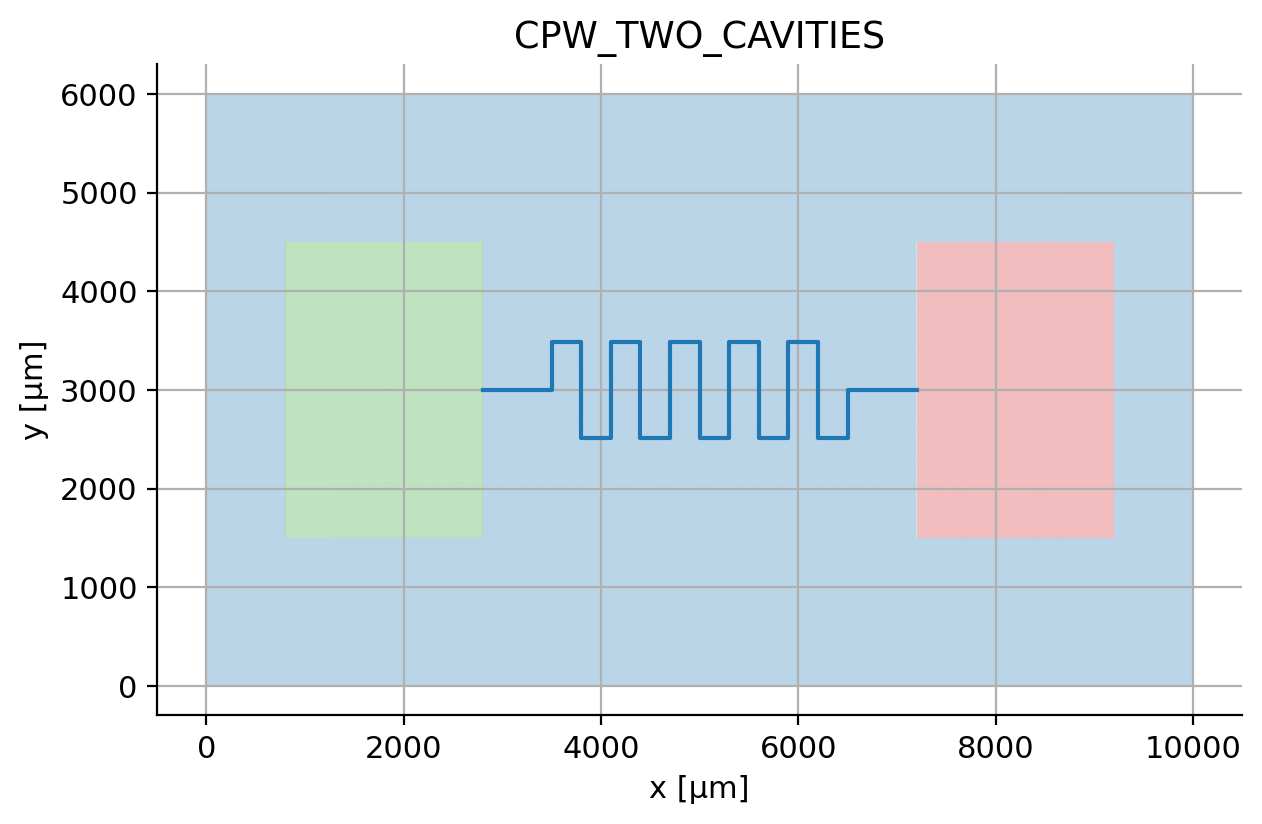

In [9]:
def main() -> None:
    """Build and preview the CPW + cavities + ground + antidots (separate layer)."""
    config = ChipConfig()
    library = build_cpw_meander_between_cavities(config)
    preview_top_cell(library, config)


if __name__ == "__main__":
    main()